<a href="https://colab.research.google.com/github/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/blob/main/Module_1/LAB_1/M1_Lab_Session_1_2_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 10: Logistic Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

Edited and presented for University of San Diego by Dillon Orr, 2022

## Import required packages

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import dmba

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

## Sample dataset

In [ ]:
delays_df = dmba.load_data('FlightDelays.csv')
delays_df.sample(20)

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
1089,1455,DH,1454,JFK,228,1/16/2004,7808,IAD,0,5,16,N307UE,ontime
251,1730,DL,1730,LGA,214,01/05/2004,1762,DCA,0,1,5,N225DL,ontime
55,640,DH,645,LGA,229,01/02/2004,7790,IAD,0,5,2,N686BR,ontime
1484,1500,US,1456,LGA,214,1/21/2004,2176,DCA,0,3,21,N713UW,ontime
1353,1040,DH,1033,LGA,229,1/20/2004,7792,IAD,0,2,20,N646BR,ontime
1880,1030,DL,1032,LGA,214,1/27/2004,1748,DCA,0,2,27,N225DL,ontime
2175,1300,MQ,1254,LGA,214,1/31/2004,4964,DCA,0,6,31,N710MQ,ontime
42,1700,RU,1651,EWR,213,01/01/2004,2497,IAD,0,4,1,N12540,ontime
982,1700,US,1653,LGA,214,1/14/2004,2180,DCA,0,3,14,N739UW,ontime
1376,2030,DL,2029,LGA,214,1/20/2004,1768,DCA,0,2,20,N223DZ,ontime


## Figure 10.4

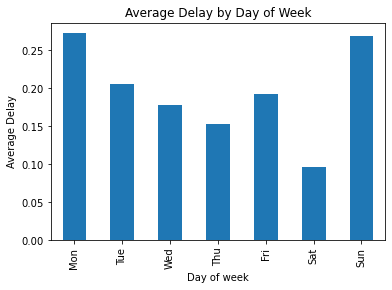

In [ ]:
delays_df = dmba.load_data('FlightDelays.csv')

# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']]

# group information by day of week and determine the average delay
averageDelay = delays_df.groupby(['DAY_WEEK'])['isDelayed'].mean()

# create a bar chart
ax = averageDelay.plot.bar(color='C0')
ax.set_xlabel('Day of week')
ax.set_ylabel('Average Delay')
ax.set_title('Average Delay by Day of Week')
_ = ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

Visualizing delays by various predictors

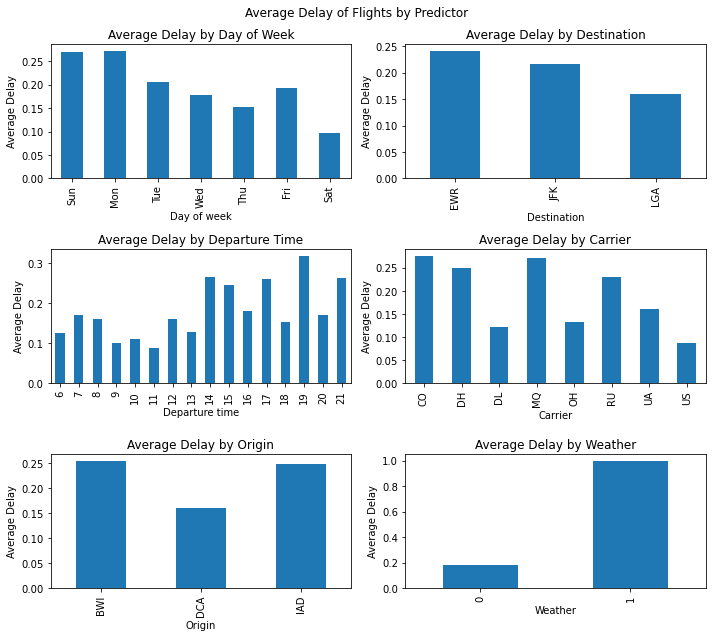

In [ ]:
delays_df = dmba.load_data('FlightDelays.csv')

# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

def createGraph(group, xlabel, axis) -> plt.Axes: # adding type hint
    groupAverage = delays_df.groupby([group])['isDelayed'].mean()
    if group == 'DAY_WEEK': # rotate so that display starts on Sunday
        groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index,1))
        groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

def graphDepartureTime(xlabel, axis) -> plt.Axes: # adding type hint
    temp_df = pd.DataFrame({'CRS_DEP_TIME': delays_df['CRS_DEP_TIME'] // 100, 
                            'isDelayed': delays_df['isDelayed']})
    groupAverage = temp_df.groupby(['CRS_DEP_TIME'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_xlabel(xlabel); ax.set_ylabel('Average Delay')
    
    return ax
    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))

# add suptitle
fig.suptitle('Average Delay of Flights by Predictor')

# added titles to below
ax0 = createGraph('DAY_WEEK', 'Day of week', axis=axes[0][0])
ax0.set_title('Average Delay by Day of Week')

ax1 = createGraph('DEST', 'Destination', axis=axes[0][1])
ax1.set_title('Average Delay by Destination')

ax2 = graphDepartureTime('Departure time', axis=axes[1][0])
ax2.set_title('Average Delay by Departure Time')

ax3 = createGraph('CARRIER', 'Carrier', axis=axes[1][1])
ax3.set_title('Average Delay by Carrier')

ax4 = createGraph('ORIGIN', 'Origin', axis=axes[2][0])
ax4.set_title('Average Delay by Origin')

ax5 = createGraph('Weather', 'Weather', axis=axes[2][1])
ax5.set_title('Average Delay by Weather')

plt.tight_layout()

plt.show()

## Figure 10.5

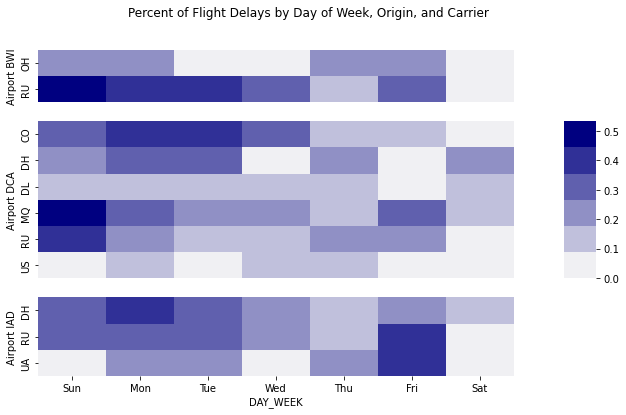

In [ ]:
agg = delays_df.groupby(['ORIGIN', 'DAY_WEEK', 'CARRIER']).isDelayed.mean()
agg = agg.reset_index()

# Define the layout of the graph
height_ratios = []
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    height_ratios.append(len(agg[agg.ORIGIN == origin].CARRIER.unique()))
gridspec_kw = {'height_ratios': height_ratios, 'width_ratios': [15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), 
                         gridspec_kw = gridspec_kw)
axes[0, 1].axis('off')
axes[2, 1].axis('off')

maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    data = pd.pivot_table(agg[agg.ORIGIN == origin], values='isDelayed', aggfunc=np.sum, 
                          index=['CARRIER'], columns=['DAY_WEEK'])
    data = data[[7, 1, 2, 3, 4, 5, 6]]  # Shift last columns to first
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0, vmax=maxIsDelay, 
                     cbar_ax=axes[1][1], cmap=sns.light_palette("navy"))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    if i != 2: 
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Airport ' + origin)
    
fig.suptitle('Percent of Flight Delays by Day of Week, Origin, and Carrier')
    
plt.show()

## Table 10.7

In [ ]:
delays_df = dmba.load_data('FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'isDelayed'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 33)
print('intercept ', logit_full.intercept_[0], '\n')

# could use display() to present this cleaner, but for illustration, leaving as-is
print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=X.columns).transpose())
print('\nAIC', AIC_score(valid_y, logit_full.predict(valid_X), df=len(train_X.columns) + 1))

pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -1.2190996255195397 

       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  DAY_WEEK_7  \
coeff    9.325      -0.598      -0.705      -0.799      -0.296      -1.129      -0.135   

       CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  CRS_DEP_TIME_10  CRS_DEP_TIME_11  \
coeff           0.631           0.382          -0.365            0.337            0.078   

       CRS_DEP_TIME_12  CRS_DEP_TIME_13  CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  \
coeff            0.399            0.175            0.202            1.265            0.628   

       CRS_DEP_TIME_17  CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff            1.093            0.285            1.655            1.023            1.077   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  CARRIER_MQ  \
coeff       -0.01      -0.134    -0.524    -0.546       0.352      -0.685       0.743   

       CARRIER_OH  CARRIER_RU  CARRIER_UA  CAR

## Figure 10.6

Confusion Matrix (Accuracy 0.8309)

        Prediction
 Actual  ontime delayed
 ontime     705       9
delayed     140      27


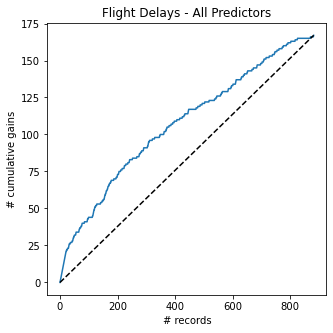

In [ ]:
logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(full_result.actual, full_result.predicted, class_names=classes)

ax0 = gainsChart(full_result.actual, figsize=[5, 5])
ax0.set_title('Flight Delays - All Predictors')
plt.show()

## Table 10.9

In [ ]:
# quick groupby/pivot example to re-create table 10.9
delays_df = dmba.load_data('FlightDelays.csv')

# delays_df

# group by carrier, origin, name values = FLIGHTS
grouped_df = delays_df.groupby(['CARRIER', 'ORIGIN'], as_index=False).size().rename(columns={'size':'FLIGHTS'})
# grouped_df

# pivot by carrier, origin, display FLIGHTS
pivoted_df = grouped_df.pivot(index='CARRIER', columns='ORIGIN', values='FLIGHTS')
# pivoted_df

# add total column and rows
summed_df = pivoted_df.copy()
summed_df['Total'] = summed_df.sum(axis=1)
summed_df.loc['Total'] = summed_df.sum()
display(summed_df)

ORIGIN,BWI,DCA,IAD,Total
CARRIER,,,,
CO,NaN,94.0,NaN,94.0
DH,NaN,27.0,524.0,551.0
DL,NaN,388.0,NaN,388.0
MQ,NaN,295.0,NaN,295.0
OH,30.0,NaN,NaN,30.0
RU,115.0,162.0,131.0,408.0
UA,NaN,NaN,31.0,31.0
US,NaN,404.0,NaN,404.0
Total,145.0,1370.0,686.0,2201.0


## Table 10.10

In [ ]:
delays_df = dmba.load_data('FlightDelays.csv')
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]
delays_df['CRS_DEP_TIME'] = [round(t / 100) for t in delays_df['CRS_DEP_TIME']]
delays_red_df = pd.DataFrame({
    'Sun_Mon' : [1 if d in (1, 7) else 0 for d in delays_df.DAY_WEEK],
    'Weather' : delays_df.Weather,
    'CARRIER_CO_MQ_DH_RU' : [1 if d in ("CO", "MQ", "DH", "RU") else 0 
                             for d in delays_df.CARRIER],
    'MORNING' : [1 if d in (6, 7, 8, 9) else 0 for d in delays_df.CRS_DEP_TIME],
    'NOON' : [1 if d in (10, 11, 12, 13) else 0 for d in delays_df.CRS_DEP_TIME],
    'AFTER2P' : [1 if d in (14, 15, 16, 17, 18) else 0 for d in delays_df.CRS_DEP_TIME],
    'EVENING' : [1 if d in (19, 20) else 0 for d in delays_df.CRS_DEP_TIME],
    'isDelayed' : [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']],
})

X = delays_red_df.drop(columns=['isDelayed'])
y = delays_red_df['isDelayed']
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

logit_red = LogisticRegressionCV(penalty="l1", solver='liblinear', cv=5)
logit_red.fit(train_X, train_y)

print('regularization', logit_red.C_, '\n')
print('intercept ', logit_red.intercept_[0], '\n')

display(pd.DataFrame({'coeff': logit_red.coef_[0]}, index=X.columns).transpose())

print('\nAIC', AIC_score(valid_y, logit_red.predict(valid_X), df=len(train_X.columns) + 1), '\n')

# confusion matrix
classificationSummary(valid_y, logit_red.predict(valid_X), class_names=classes)

regularization [2.7825594] 

intercept  -2.2874231094862276 



,Sun_Mon,Weather,CARRIER_CO_MQ_DH_RU,MORNING,NOON,AFTER2P,EVENING
coeff,0.577932,4.977944,1.298899,-0.583286,-0.665857,-0.05517,0.560912



AIC 934.6153607819033 

Confusion Matrix (Accuracy 0.8343)

        Prediction
 Actual  ontime delayed
 ontime     711       3
delayed     143      24


## Figure 10.7

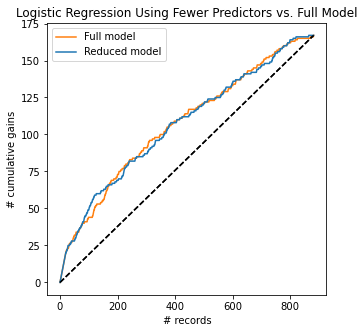

In [ ]:
logit_reg_proba = logit_red.predict_proba(valid_X)
red_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_proba],
                            'p(1)': [p[1] for p in logit_reg_proba],
                            'predicted': logit_red.predict(valid_X),
                          })
red_result = red_result.sort_values(by=['p(1)'], ascending=False)

ax = gainsChart(full_result.actual, label='Full model', color='C1', figsize=[5, 5])
ax = gainsChart(red_result.actual, label='Reduced model', color='C0', ax=ax)
ax.legend()
ax.set_title('Logistic Regression Using Fewer Predictors vs. Full Model')

plt.show()